In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [ ]:
from plotnine import ggplot, aes, geom_bar, theme_minimal, labs, theme
from plotnine.themes import element_text, element_rect

# mpl.style.use('ggplot')
# plt.style.use('default')
sns.set_style('darkgrid')
gg = ggplot() + \
     theme(plot_title=element_text(hjust=0.5))

In [3]:
data = pd.read_csv("/content/drive/MyDrive/data.csv", encoding = 'unicode_escape')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


* **InvoiceNo**: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'C', it indicates orders which brings negative revenue.
* **StockCode**: Product (item) code. Nominal.
 * a 5-digit integral number uniquely assigned to each distinct product.
 * other StockCodes which don't contain 5-digit integral number have different meanings.
* **Description**: Product (item) name. Nominal.
* **Quantity**: The quantities of each product (item) per transaction. Numeric.
* **InvoiceDate**: Invice Date and time. Numeric, the day and time when each transaction was generated.
* **UnitPrice**: Unit price. Numeric, Product price per unit in sterling.
* **CustomerID**: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
* **Country**: Country name. Nominal, the name of the country where each customer resides.

（D、M、BANK CHARGES這三種StockCode有可能會有負的數量，另外其他負的數量是退貨）

# Data Preprocessing

## 1. Dropping missing values
As the information said, there are null values in Description and CustomerID columns. I decided take a closer look to decide whether to remove them or not.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
data[data.CustomerID.isna()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom


In [6]:
data[data.Description.isna()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,12/1/2010 14:32,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,12/1/2010 14:34,0.0,NaN,United Kingdom


Since we are implementing customer segmentation, rows which contain no CustomerID can be deleted. However, it seems fine to keep rows with empty Description. I considered that each Description value corresponded to a specific StockCode and some of the Description values were empty probably becaues the company forgot to fill them for some reasons.

In [7]:
data.dropna(subset=['CustomerID'], inplace=True)

## 2. Revising data format

After observing the format of data, I decided to change InvoiceDate into datetime format for potential analysis about time.

In [8]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], format='%m/%d/%Y %H:%M')

In [9]:
data.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

## 3. Removing non-reasonable data
After exploring variables, I found that Quantity could be negative, which was probably due to cancellation. I also noticed that cancelling orders corresponed to orders that would have been made before and every order with negative Quantity would have InvoiceNo started with C.

Below is an example of the cancelling order corresponed to the purchasing order that had been made before.

In [10]:
data[(data['CustomerID'] == 16446)].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
194354,553573,22980,PANTRY SCRUBBING BRUSH,1,2011-05-18 09:52:00,1.65,16446.0,United Kingdom
194355,553573,22982,PANTRY PASTRY BRUSH,1,2011-05-18 09:52:00,1.25,16446.0,United Kingdom
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2011-12-09 09:27:00,2.08,16446.0,United Kingdom


Prove the hypothesis that every order with negative Quantity must has a InvoiceNo started with C.

In [11]:
check = True
for index, row in data.loc[data['Quantity'] < 0].iterrows():
  if not 'C' in row['InvoiceNo']:
    check = False
    break

if check:
  print('Every order with negative Quantity must has a InvoiceNo started with C.')
else:
  print('Not every order with negative Quantity has a InvoiceNo started with C.')

Every order with negative Quantity must has a InvoiceNo started with C.


Despite cancelling cases, there are other reasons why the Quantity is negative such as discount and postage.

In [12]:
neg_code = sorted(data[data.Quantity < 0][~(data[data.Quantity < 0]).StockCode.str.contains(r'\d\d\d\d\d')].StockCode.unique())
neg_des = sorted(data[data['StockCode'].isin(neg_code)].Description.unique())
print('Negative quantity cases existed in the following codes.')
pd.DataFrame({'StockCode': neg_code, 'Description': neg_des})

Negative quantity cases existed in the following codes.


,StockCode,Description
0,C2,CARRIAGE
1,CRUK,CRUK Commission
2,D,Discount
3,M,Manual
4,POST,POSTAGE


With above observation, I decided to eliminate cancelling orders which didn't have counterpart. This situation happened probably because purchasing records were earlier than 2010/12/01 where the dataset started.

In both purchaseing and cancalling orders, "StockCode, Description, UnitPrice, CustomerID, Country" will be the same and the product you cancel must be later than the order you have made. Also, the quantity purchased should be more than the quantity cancelled. Thus, I utilized these patterns to erase non-reasonable orders.

Below is an example of the cancelling order with no counterpart.

In [13]:
data[data['CustomerID'] == 17548].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
239,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,2010-12-01 10:24:00,3.45,17548.0,United Kingdom


In [14]:
def find_counterpart(row):
    counterpart = data[
        (data['CustomerID'] == row['CustomerID']) &
        (data['StockCode'] == row['StockCode']) &
        (data['InvoiceDate'] < row['InvoiceDate']) &
        (data['Quantity'] >= abs(row['Quantity']))
    ].copy()
    return counterpart.shape[0] == 0

mask = (data['Quantity'] < 0) & (~data['StockCode'].isin(neg_code))
cancelling_cases = data[mask]

index_to_drop = cancelling_cases[cancelling_cases.apply(find_counterpart, axis=1)].index

print('There are', len(index_to_drop), 'cancelling cases without counterpart.')

There are 1115 cancelling cases without counterpart.


In [15]:
data = data.drop(index=index_to_drop)

After removing those entries, there were still some customers who only had negative records in Quantity.

In [16]:
grouped_data = data.groupby(by=['CustomerID'], as_index=False)
customer_to_delete = []

for id in data.CustomerID.unique():
  if (grouped_data.get_group(id)['Quantity'] > 0).values.any():
    continue
  customer_to_delete.append(id)

print('There were ' + str(len(customer_to_delete)) + ' customers who only had negative records in Quantity.')

There were 7 customers who only had negative records in Quantity.


In [17]:
data[data['CustomerID'].isin(customer_to_delete)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
45622,C540271,M,Manual,-1,2011-01-06 11:51:00,1126.00,12503.0,Spain
88000,C543743,M,Manual,-1,2011-02-11 13:39:00,4.50,12505.0,Italy
100457,C544814,M,Manual,-1,2011-02-23 16:36:00,30.19,15590.0,United Kingdom
268027,C560372,M,Manual,-1,2011-07-18 12:26:00,4287.63,17448.0,United Kingdom
268431,C560420,M,Manual,-1,2011-07-18 15:11:00,1592.49,15369.0,United Kingdom
268476,C560430,M,Manual,-1,2011-07-18 15:21:00,611.86,13154.0,United Kingdom
270557,C560572,M,Manual,-1,2011-07-19 14:45:00,112.35,17065.0,United Kingdom


In [18]:
data = data[~data['CustomerID'].isin(customer_to_delete)]

## 4. Building new variables


### Revenue

For further analysis, I created a variable called Revenue which was Quantity times UnitPrice.

In [77]:
data.loc[:, ['Revenue']] = data['Quantity'] * data['UnitPrice']
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


### Recency
Recency meant how many days since the customer's last purchase. The lower the recency, the more active the customer.

In [ ]:
lastDate = max(data['InvoiceDate'])
startDate = min(data['InvoiceDate'])
recency = data[['CustomerID', 'InvoiceDate']].where(data['Quantity'] > 0).groupby(data['CustomerID'], as_index=False).max()
recency.columns = ['CustomerID','LastPurchaseTime']
recency['Recency'] = recency['LastPurchaseTime'].apply(lambda x: (lastDate - x).days)
recency = recency.dropna(how='all')

recency = recency.sort_values(by=['CustomerID'], ascending=True)
recency.head()

,CustomerID,LastPurchaseTime,Recency
0,12346.0,2011-01-18 10:01:00,325
1,12347.0,2011-12-07 15:52:00,1
2,12348.0,2011-09-25 13:13:00,74
3,12349.0,2011-11-21 09:51:00,18
4,12350.0,2011-02-02 16:01:00,309


### Monetary
Monetary represented the total revenue a customer spend during 2010/12 to 2011/12. The higher the monetary, the more important the customer was to the company.

In [ ]:
monetary = data[['CustomerID','Revenue']].groupby(['CustomerID'], as_index=False).sum()
monetary = monetary.sort_values(by=['CustomerID'], ascending=True)
monetary.columns = ['CustomerID','Monetary']
monetary.head()

,CustomerID,Monetary
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


### Frequency
Frequency implied how many times a customer had made a purchase. An unique inoice number meant a single purchase. The higher the frequency, the more loyal the customer.

In [ ]:
frequency = data.where(data['Quantity'] > 0).groupby(by=['CustomerID'], as_index=False)['InvoiceNo'].nunique()
frequency.columns = ['CustomerID','Frequency']

frequency = frequency.sort_values(by=['CustomerID'], ascending=True)
frequency.head()

,CustomerID,Frequency
0,12346.0,1
1,12347.0,7
2,12348.0,4
3,12349.0,1
4,12350.0,1


Combine these three aspects into one dataframe called RFM.

In [ ]:
RFM = recency.join(frequency.set_index('CustomerID'), on=['CustomerID'])
RFM = RFM.join(monetary.set_index('CustomerID'), on=['CustomerID'])
RFM = RFM.drop('LastPurchaseTime', axis='columns')
RFM.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,1,0.00
1,12347.0,1,7,4310.00
2,12348.0,74,4,1797.24
3,12349.0,18,1,1757.55
4,12350.0,309,1,334.40


Check if there was any empty data.

In [ ]:
print(RFM.isnull().values.any())

False


Take a brief look of RFM variables.

In [ ]:
RFM.describe()

,CustomerID,Recency,Frequency,Monetary
count,4339.000000,4339.000000,4339.000000,4339.000000
mean,15299.936852,91.518322,4.271952,1920.458187
std,1721.889758,100.009747,7.705493,8254.065897
min,12346.000000,0.000000,1.000000,-1165.300000
25%,13812.500000,17.000000,1.000000,301.160000
50%,15299.000000,50.000000,2.000000,656.790000
75%,16778.500000,141.000000,5.000000,1624.035000
max,18287.000000,373.000000,210.000000,279489.020000


In [ ]:
# fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(6,6))
# fig.suptitle('Original RFM Data\n', size = 25)

# sns.boxplot(ax=axes[0], data=RFM['Recency'], palette='Spectral').set_title('Recency')
# sns.boxplot(ax=axes[1], data=RFM['Frequency'], palette='Spectral').set_title('Frequency')
# sns.boxplot(ax=axes[2], data=RFM['Monetary'], palette='Spectral').set_title('Monetary')

# plt.tight_layout()

Since I am going to use distance-based algorithms later and significant differences in numerical ranges and different units can affect the results, standardization is applied to avoid this situation.

In [ ]:
scaler = StandardScaler()
RFM_scaled = scaler.fit_transform(RFM)
RFM_scaled = pd.DataFrame(RFM_scaled)
RFM_scaled = RFM_scaled.drop(0, axis = 1)
RFM_scaled.columns = ['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled']
RFM_scaled.head()

,Recency_scaled,Frequency_scaled,Monetary_scaled
0,2.334858,-0.424675,-0.232695
1,-0.905199,0.354080,0.289532
2,-0.175186,-0.035297,-0.014930
3,-0.735196,-0.424675,-0.019739
4,2.174855,-0.424675,-0.192177


After standardization, the RFM data becomes as below.

In [ ]:
RFM_scaled.describe()

,Recency_scaled,Frequency_scaled,Monetary_scaled
count,4.339000e+03,4.339000e+03,4.339000e+03
mean,7.532834e-17,1.965087e-17,1.801330e-17
std,1.000115e+00,1.000115e+00,1.000115e+00
min,-9.151995e-01,-4.246749e-01,-3.738901e-01
25%,-7.451965e-01,-4.246749e-01,-1.962045e-01
50%,-4.151906e-01,-2.948824e-01,-1.531141e-01
75%,4.948256e-01,9.449517e-02,-3.591652e-02
max,2.814867e+00,2.670196e+01,3.363198e+01


In [ ]:
# fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(6,6))
# fig.suptitle('Normalized RFM Data\n', size = 25)

# sns.boxplot(ax=axes[0], data=RFM_scaled['Recency_scaled'], palette='Spectral').set_title('Recency')
# sns.boxplot(ax=axes[1], data=RFM_scaled['Frequency_scaled'], palette='Spectral').set_title('Frequency')
# sns.boxplot(ax=axes[2], data=RFM_scaled['Monetary_scaled'], palette='Spectral').set_title('Monetary')

# plt.tight_layout()

# Exploratory Data Analysis

First, take a brief view of the data.

In [20]:
data.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID,Revenue
count,405707.000000,405707,405707.000000,405707.000000,405707.000000
mean,12.143310,2011-07-10 23:24:53.467107840,3.438775,15288.328377,20.539128
min,-80995.000000,2010-12-01 08:26:00,0.000000,12346.000000,-168469.600000
25%,2.000000,2011-04-07 11:30:00,1.250000,13954.000000,4.200000
50%,5.000000,2011-07-31 13:13:00,1.950000,15152.000000,11.250000
75%,12.000000,2011-10-20 13:24:00,3.750000,16791.000000,19.500000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000,168469.600000
std,248.586721,NaN,69.008569,1713.885624,428.068179


Let's see how many numbers of unique Country, Customer ID and Invoice in the data.

In [21]:
pd.DataFrame({'Country':[data.Country.nunique()], 'CustomerID':[data.CustomerID.nunique()], 'Invoice':[data.InvoiceNo.nunique()]}, index = ['quantity'])

,Country,CustomerID,Invoice
quantity,37,4339,21867


The bar chart below showed top 5 total revenue among countries. As you can see United Kingdom significantly took the highest value in revenue because it was an UK based company.

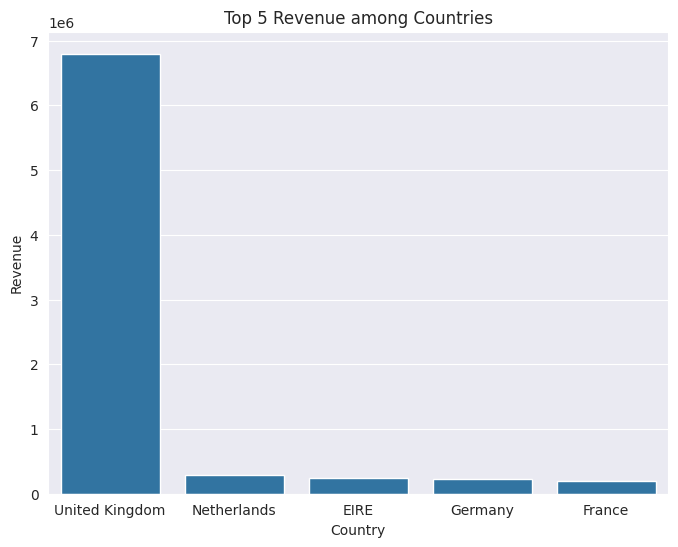

In [22]:
country_revenue = data[['Country','Revenue']].groupby(['Country'], as_index=True).sum()
country_revenue = country_revenue.sort_values(by=['Revenue'], ascending=False).reset_index().head()

fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x='Country', y='Revenue', data=country_revenue, ax=ax)
ax.set(title='Top 5 Revenue among Countries')
plt.show()

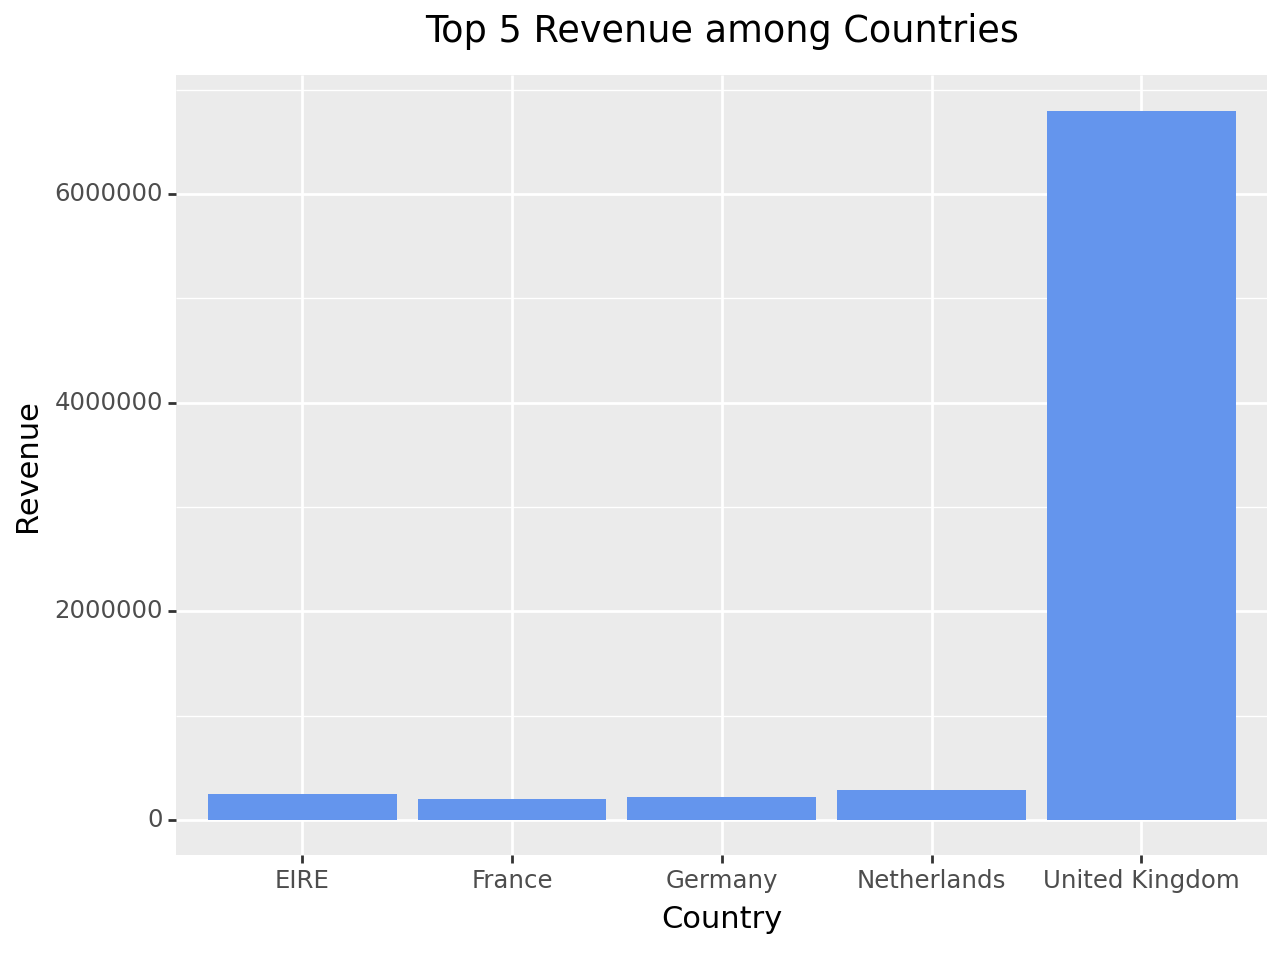

In [23]:
# from plotnine import ggplot, aes, geom_bar, theme_minimal, labs, theme
# from plotnine.themes import element_text, element_rect

# # Assuming 'data' is your DataFrame containing the data
# country_revenue = data[['Country','Revenue']].groupby(['Country'], as_index=True).sum()
# country_revenue = country_revenue.sort_values(by=['Revenue'], ascending=False).reset_index().head()

# # Create ggplot object
# gg = ggplot(country_revenue, aes(x='Country', y='Revenue')) + \
#      geom_bar(stat='identity', fill='cornflowerblue') + \
#      labs(title='Top 5 Revenue among Countries', x='Country', y='Revenue') + \
#      theme(plot_title=element_text(hjust=0.5))

# # Print the ggplot object
# print(gg)

The line chart below illustrates the trend of revenue in months. Apparently, revenue was increasing as December apporoached, which was probably because the company sold gifts to wholesalers and Christmas was the season where people liked to celebrate by exchanging gifts.

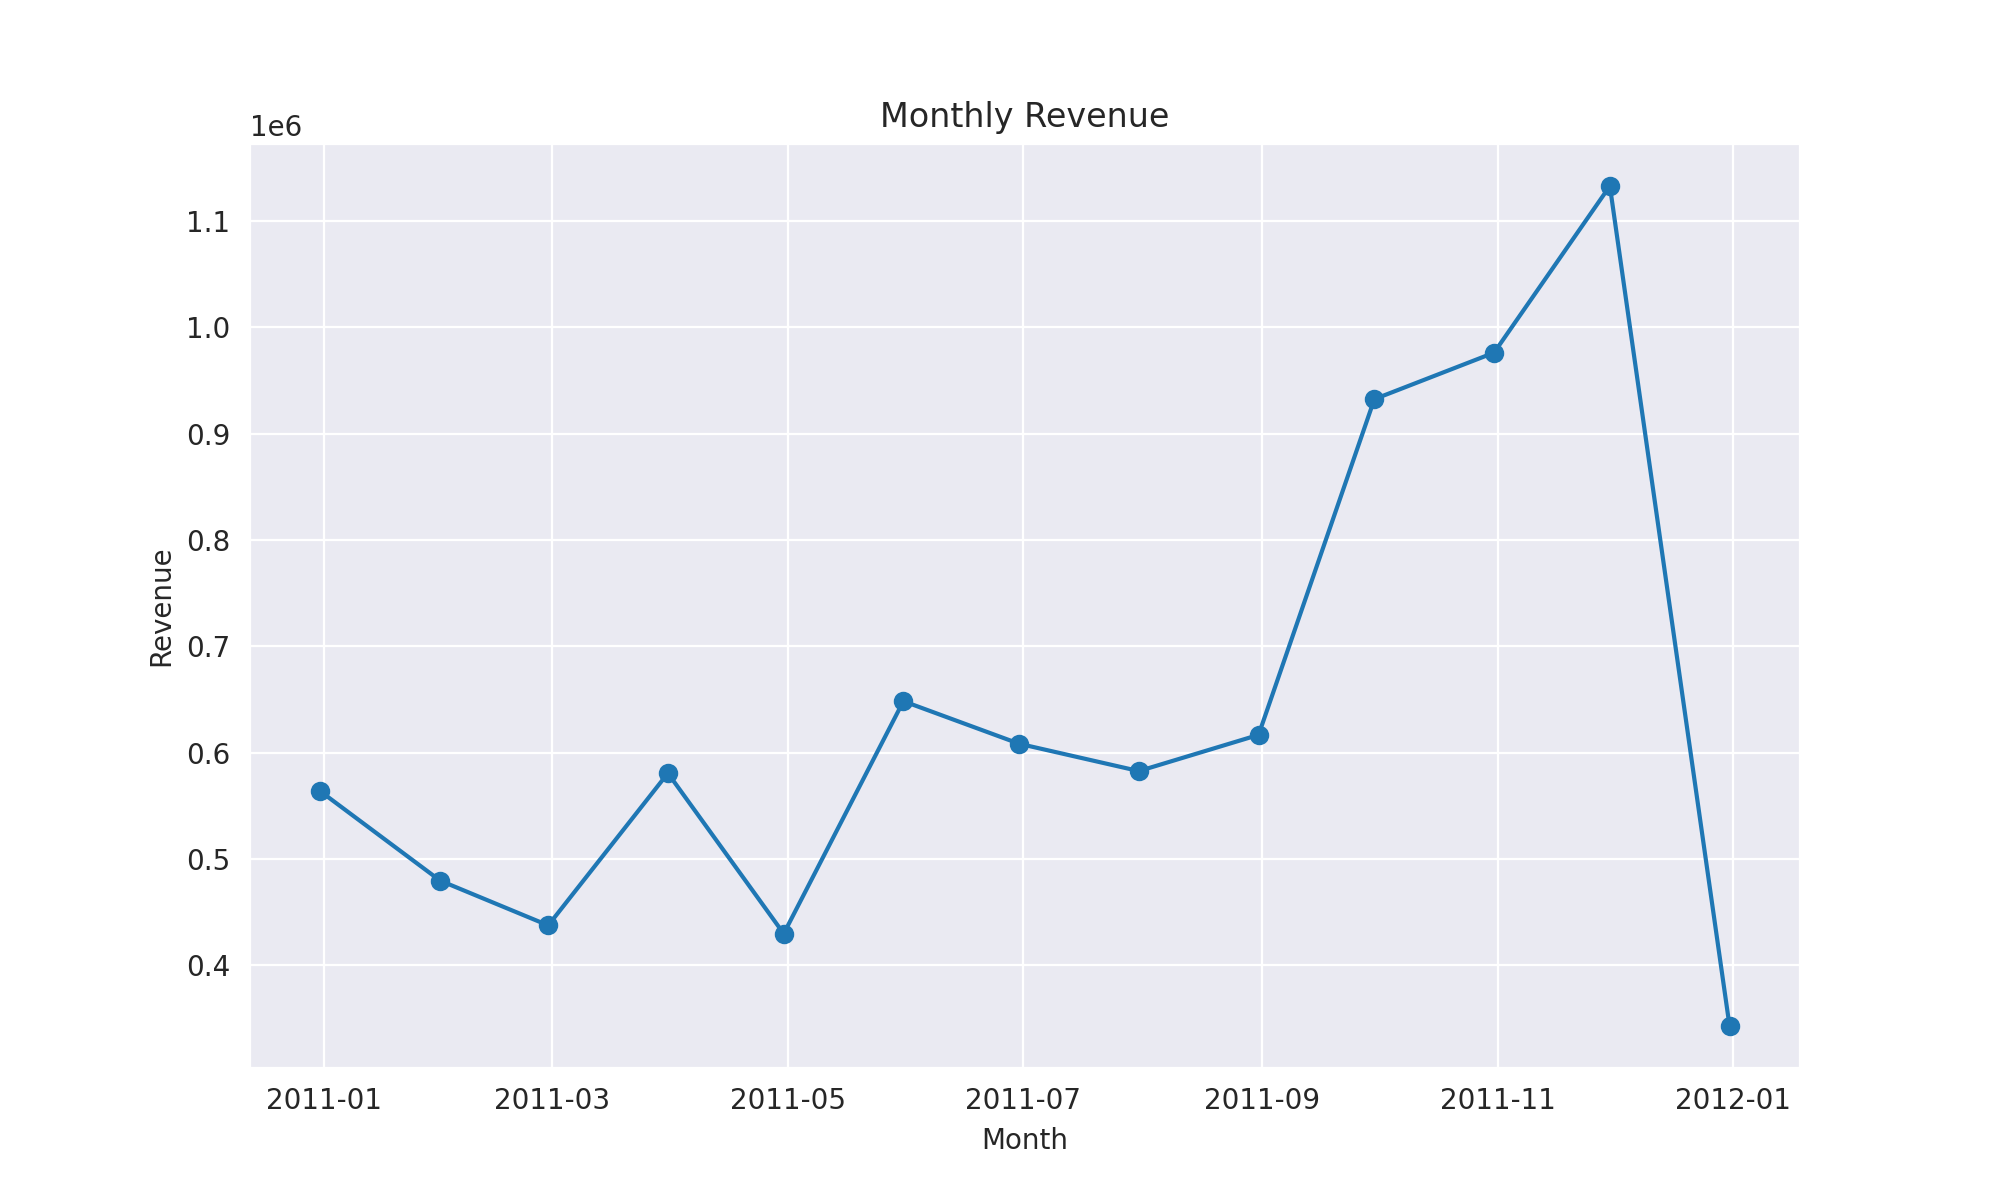

In [24]:
monthly_revenue = data.resample('M', on='InvoiceDate')['Revenue'].sum()
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(monthly_revenue.index, monthly_revenue.values, marker='o')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.title('Monthly Revenue')
plt.show()

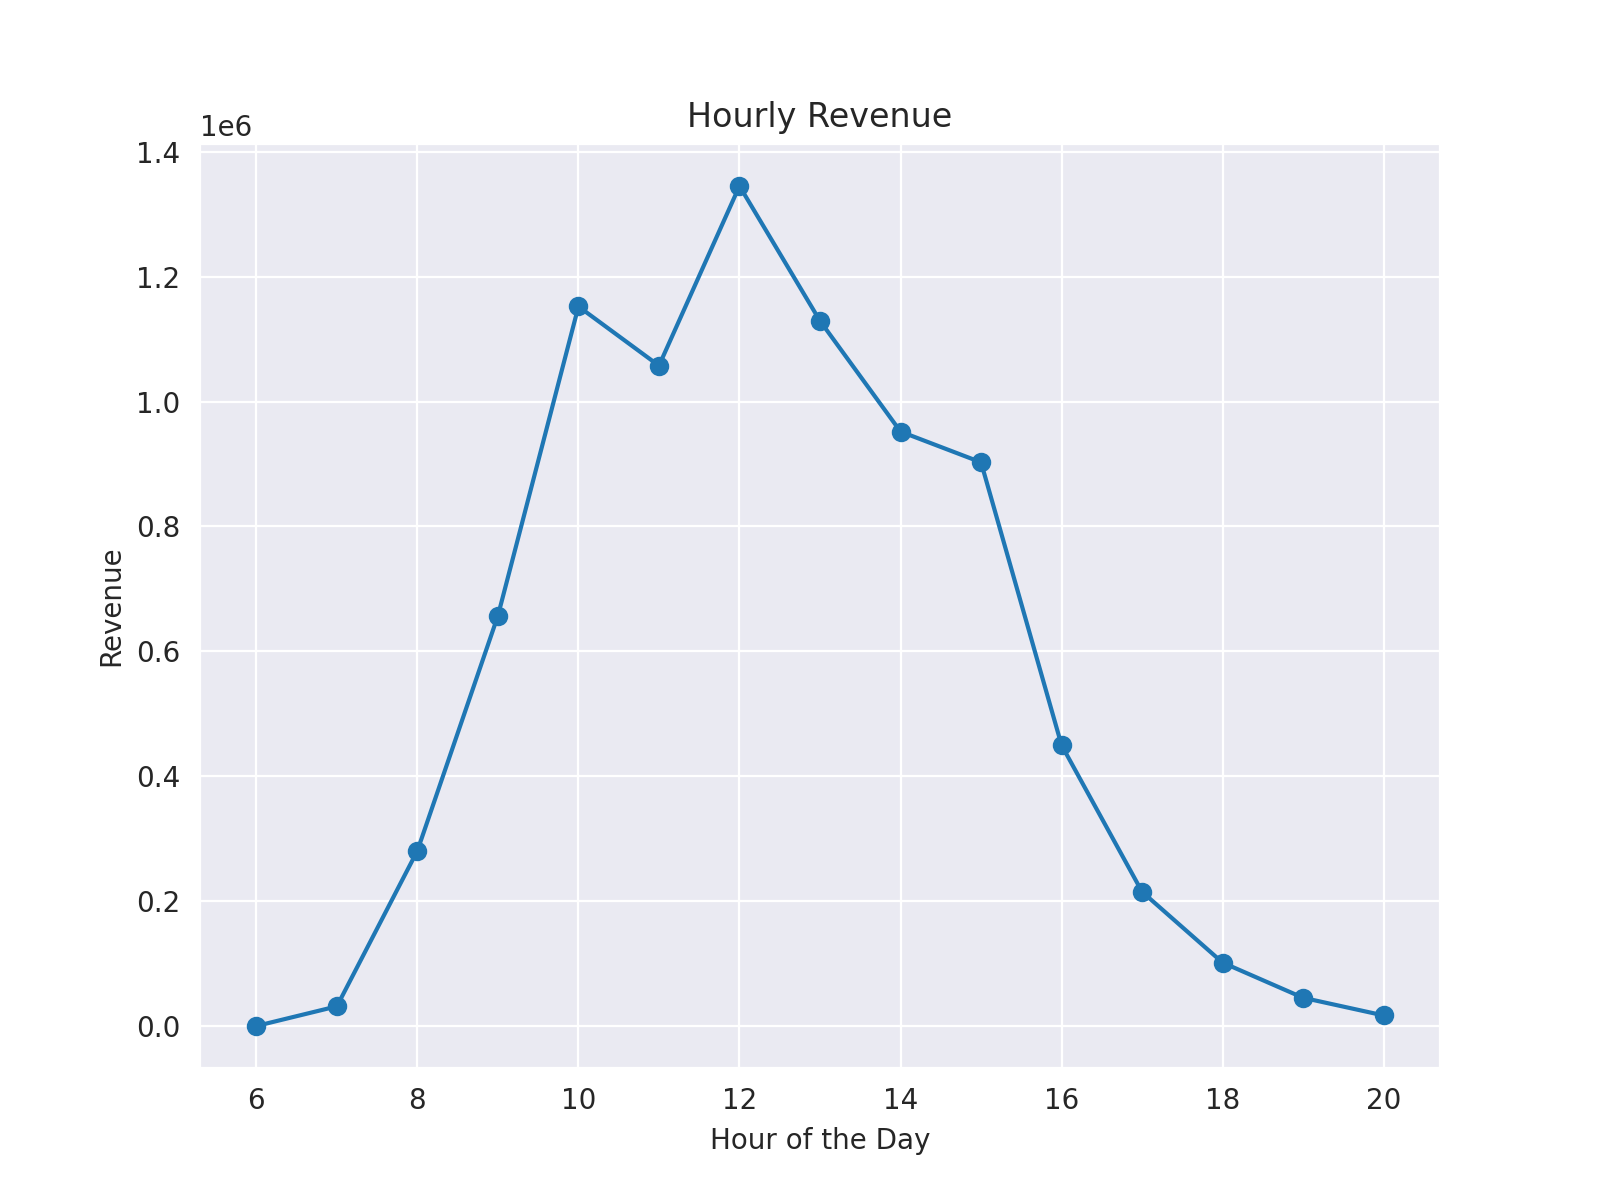

In [25]:
hourly_revenue = data[['InvoiceDate', 'Revenue']]
hourly_revenue.loc[:, ['hour']] = data['InvoiceDate'].dt.hour
hourly_revenue = hourly_revenue.groupby('hour')['Revenue'].sum()

plt.figure(figsize=(8, 6))
plt.plot(hourly_revenue.index, hourly_revenue.values, marker='o', linestyle='-')
plt.title('Hourly Revenue')
plt.xlabel('Hour of the Day')
plt.ylabel('Revenue')
plt.grid(True)
plt.show()

# Methodology

## Kmeans

K-means is an unsupervised clustering algorithm that is able to partition data into *K* different groups.

### The elbow method

After setting K clusters, the algorithm swiftly finds K centroids and completes the clustering. Once the model is fitted, we can calculate the sum of squared distances from each sample to its cluster centroid, known as sum of the squared errors (SSE), to evaluate the effectiveness of the clustering. A larger SSE indicates poorer clustering performance. As K increases, SSE tends to decrease. Normally, the maximum value of K is not chosen. Instead, the elbow point near which SSE rapidly decreases and then levels off is typically selected as the optimal K value.

I utilized the KElbowVisualizer package to obtain the SSE for each cluster size and the time it took for the algorithm to complete. The package will automatically select the optimal K value based on the SSE and runtime efficiency.

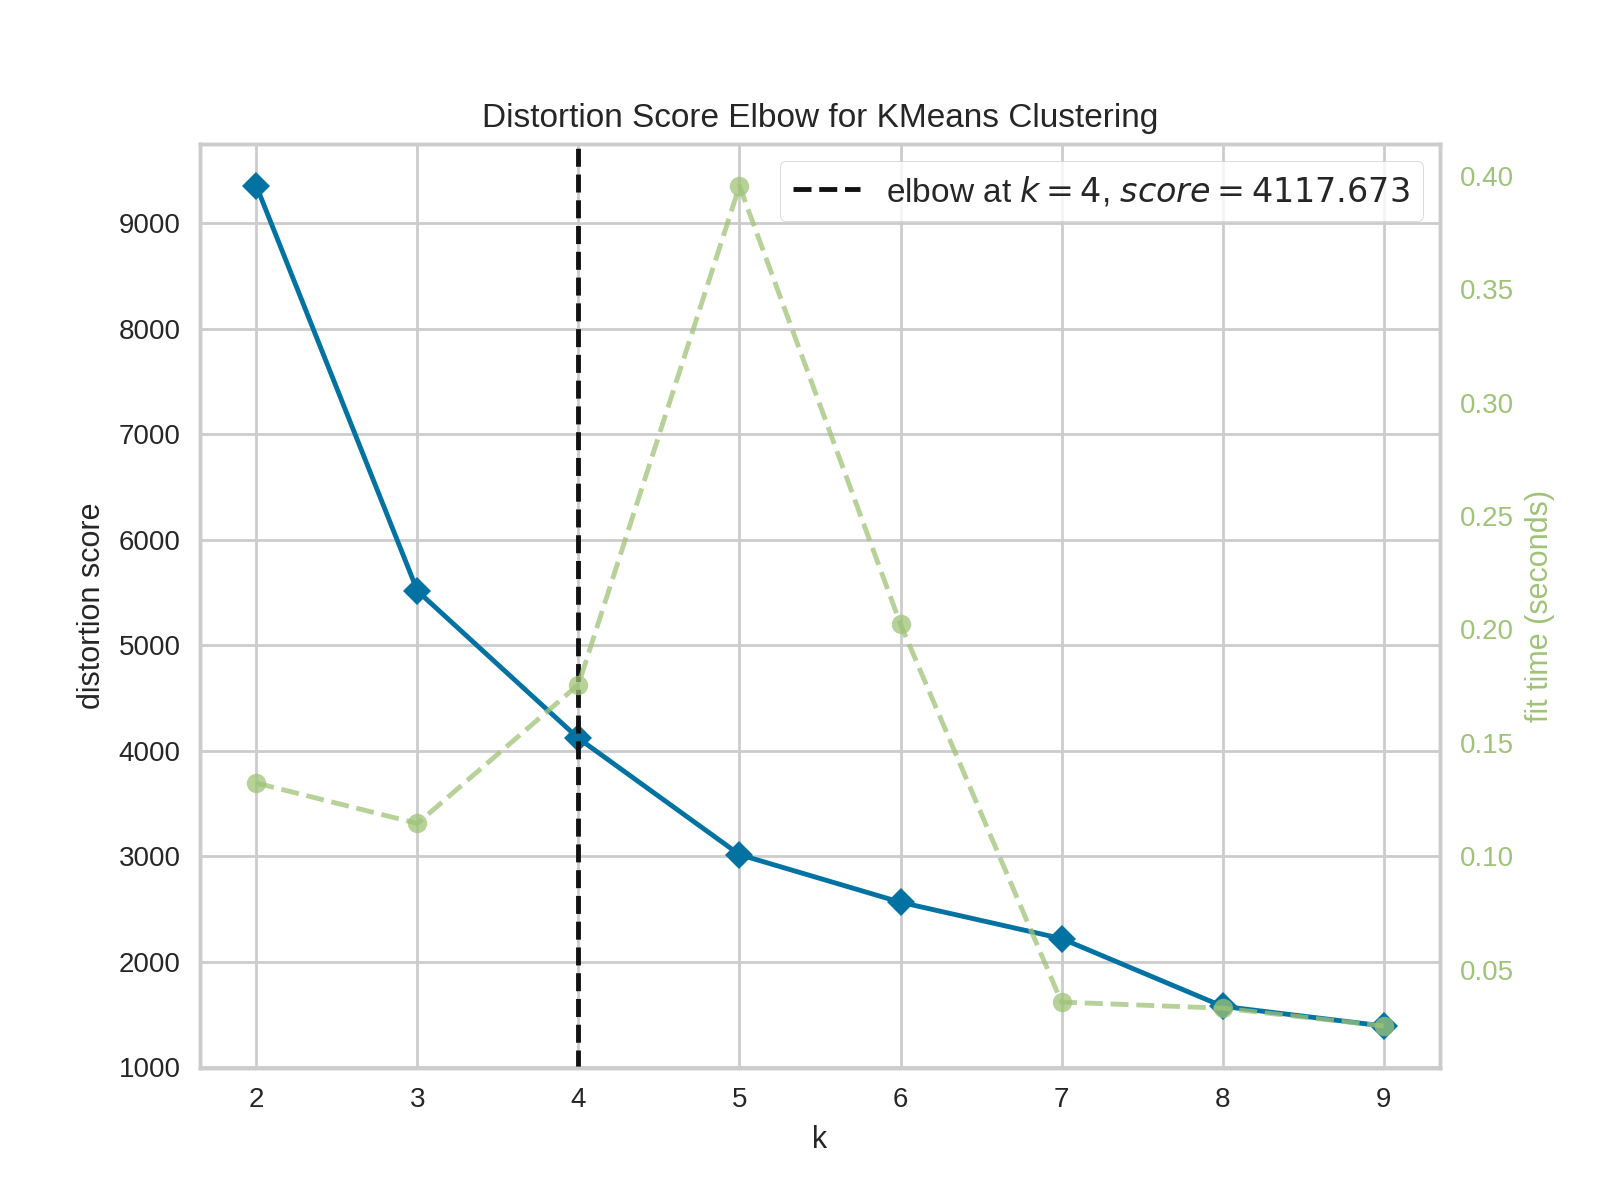

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [36]:
from yellowbrick.cluster import KElbowVisualizer

sns.set_style('darkgrid')
km = KMeans(n_init='auto', init='k-means++', random_state=42)
visualizer = KElbowVisualizer(km, k=(2,10))
plt.figure(figsize=(8, 6))
visualizer.fit(RFM_scaled)
visualizer.show()

### Silhouette score

Silhouette score is another method to choose the optimal K value. The silhouette score ranges from -1 to 1, where a higher value indicates better clustering performance.

I utilized SilhouetteVisualizer package to calculate the silhouette score  for each cluster size.

Text(0.5, 1.0, 'Silhouette Scores for Different Numbers of Clusters')

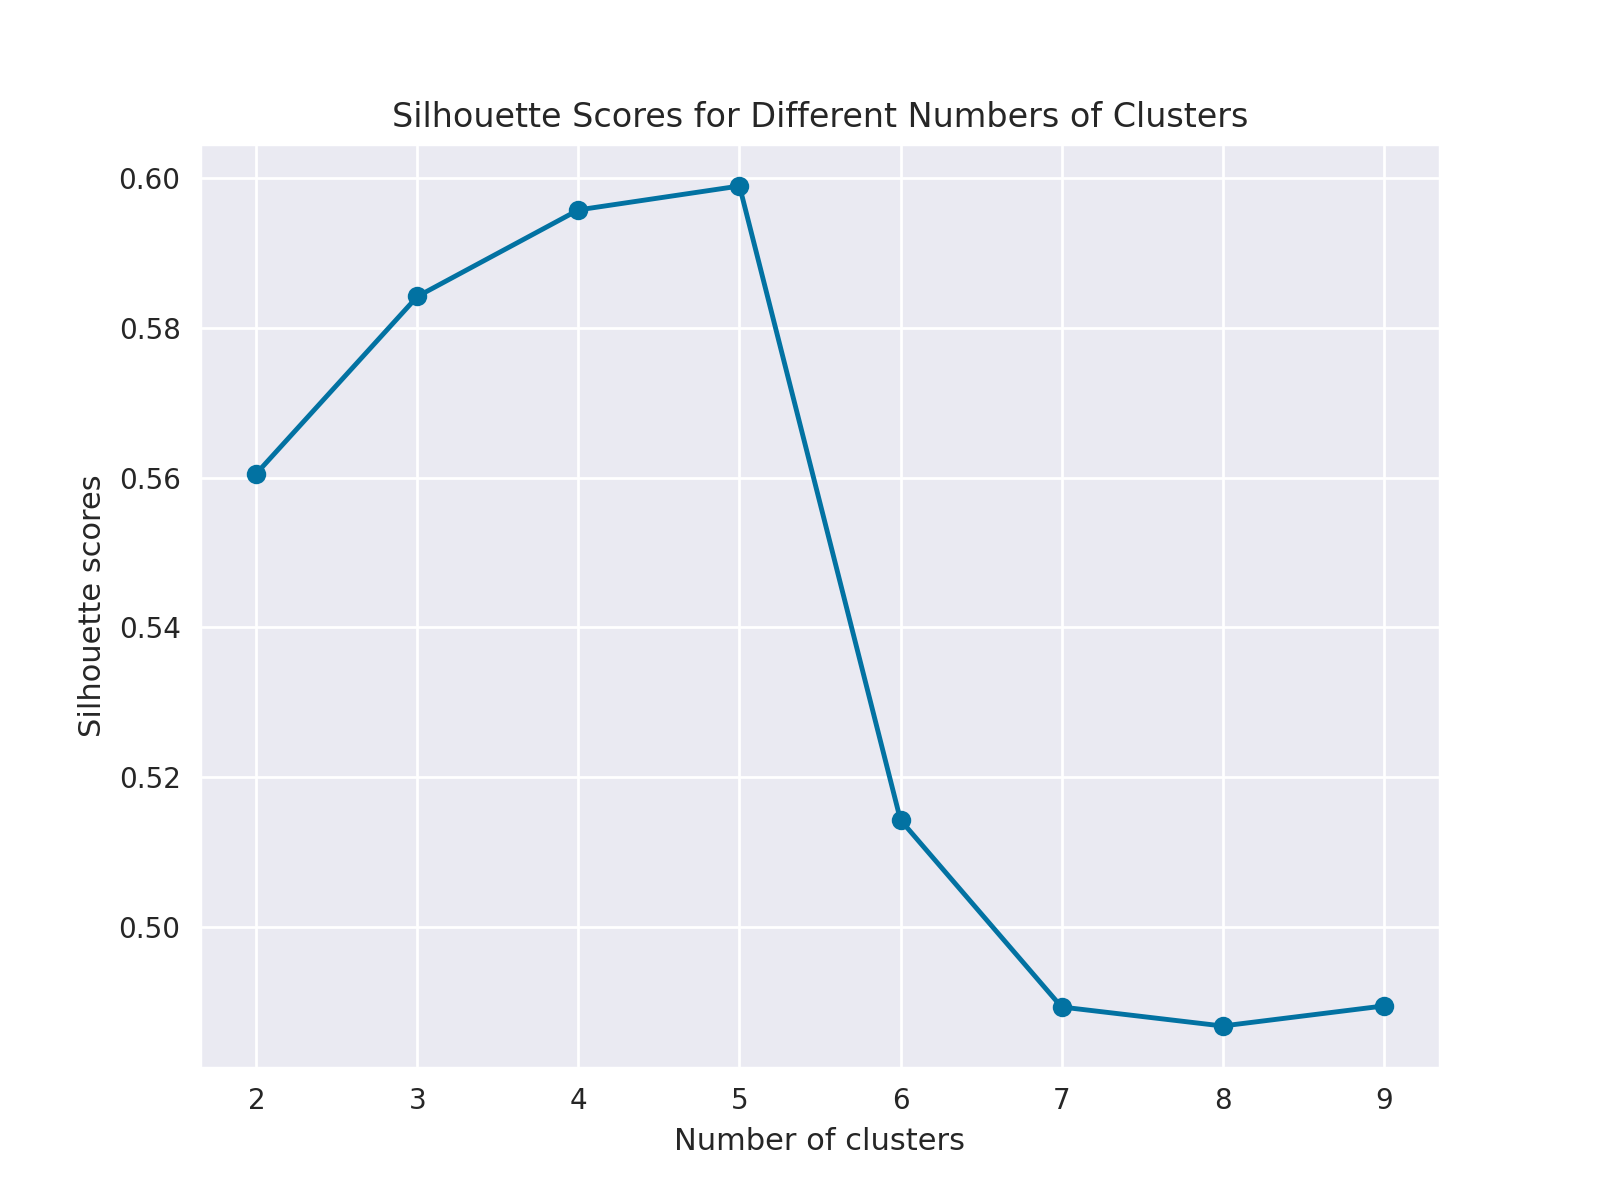

In [40]:
from sklearn.metrics import silhouette_score

scores = []
for i in range(2, 10):
  kmeans = KMeans(n_clusters=i, init='k-means++', n_init='auto', random_state=42)
  scores.append(silhouette_score(RFM_scaled, kmeans.fit_predict(RFM_scaled)))

frame = pd.DataFrame({'Cluster':range(2,10), 'silhouette_scores':scores})
sns.set_style('darkgrid')
plt.figure(figsize=(8,6))
plt.plot(frame['Cluster'], frame['silhouette_scores'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette scores')
plt.title('Silhouette Scores for Different Numbers of Clusters')

After considering the results of the elbow method and the silhouette score, it appears that four clusters offer the most optimal solution for the K-means algorithm. And now, we can finally build the K-means nodel with four clusters to continue further analysis.

In [41]:
kmeans = KMeans(n_init='auto', n_clusters = 4, init='k-means++', random_state=42)
kmeans.fit(RFM_scaled)

centroids = kmeans.cluster_centers_
kmeans_labels = np.unique(kmeans.labels_)

After creating the model, label the clusters for the result.

In [42]:
kmeans_result = RFM_scaled.copy()
kmeans_result.columns = ['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled']
kmeans_result.insert(0, 'CustomerID', RFM['CustomerID'], True)
kmeans_result = pd.DataFrame.merge(kmeans_result, RFM, on='CustomerID')
kmeans_result['Cluster'] = kmeans.labels_
kmeans_result.head()

,CustomerID,Recency_scaled,Frequency_scaled,Monetary_scaled,Recency,Frequency,Monetary,Cluster
0,12346.0,2.334858,-0.424675,-0.232695,325,1,0.00,0
1,12347.0,-0.905199,0.354080,0.289532,1,7,4310.00,1
2,12348.0,-0.175186,-0.035297,-0.014930,74,4,1797.24,1
3,12349.0,-0.735196,-0.424675,-0.019739,18,1,1757.55,1
4,12350.0,2.174855,-0.424675,-0.192177,309,1,334.40,0


To compare the RFM value from cluster to cluster, I obtain the centroids of each cluster. The centroid is is the center of the cluster which is calculated as the arithmetic mean of the data points assigned to the cluster. Importantly, the centroid itself may not correspond to any specific data point within the dataset.

In [43]:
# add cluster number into centroids to rank
values_to_append = np.array([0, 1, 2, 3])
centroids_with_cluster = np.hstack((centroids, values_to_append[:, np.newaxis]))
print(centroids_with_cluster)

[[ 1.54495505e+00 -3.48932614e-01 -1.73360464e-01  0.00000000e+00]
 [-5.10836665e-01  4.69689158e-02 -1.59416798e-02  1.00000000e+00]
 [-8.88532351e-01  7.23308326e+00  2.89849482e+01  2.00000000e+00]
 [-8.61598539e-01  8.18316444e+00  6.09017120e+00  3.00000000e+00]]


Rank the RFM value of each cluster.

In [ ]:
# centroids_RFM = []
# for i in range(0, 3):
#   value = []
#   for j in range(len(centroids_with_cluster)):
#     value.append(centroids_with_cluster[j][i])
#   centroids_RFM.append(value)

# metrics = ['Recency', 'Frequency', 'Monetary']
# sns.set_style('darkgrid')
# for i, centroid in enumerate(centroids_RFM):
#     plt.figure(figsize=(6, 4))
#     plt.bar(['0', '1', '2', '3'], centroid)
#     plt.title(metrics[i])
#     plt.xlabel('Cluster')
#     plt.ylabel('Value')
#     plt.show()

In [44]:
rankings = {
    "Recency": np.argsort(centroids_with_cluster[:, 0]),
    "Frequency": np.argsort(centroids_with_cluster[:, 1])[::-1],  # Reverse for descending order
    "Monetary": np.argsort(centroids_with_cluster[:, 2])[::-1]    # Reverse for descending order
}

for metric, ranking in rankings.items():
    ranking_lst = [str(int(row[-1])) for row in centroids_with_cluster[ranking]]
    if metric == 'Recency':
      print(f"{metric.lower()} ranking by cluster: {' < '.join(ranking_lst)}")
    else:
      print(f"{metric.lower()} ranking by cluster: {' > '.join(ranking_lst)}")

recency ranking by cluster: 2 < 3 < 1 < 0
frequency ranking by cluster: 3 > 2 > 1 > 0
monetary ranking by cluster: 2 > 3 > 1 > 0


Check the size of each cluster.

In [45]:
kmeans_result[['Cluster']].value_counts()

Cluster
1          3228
0          1083
3            25
2             3
Name: count, dtype: int64

Visualize 2D and 3D scatter chart to check the distribution of each cluster in RFM dimensions. The black points represent the centroids of clusters.

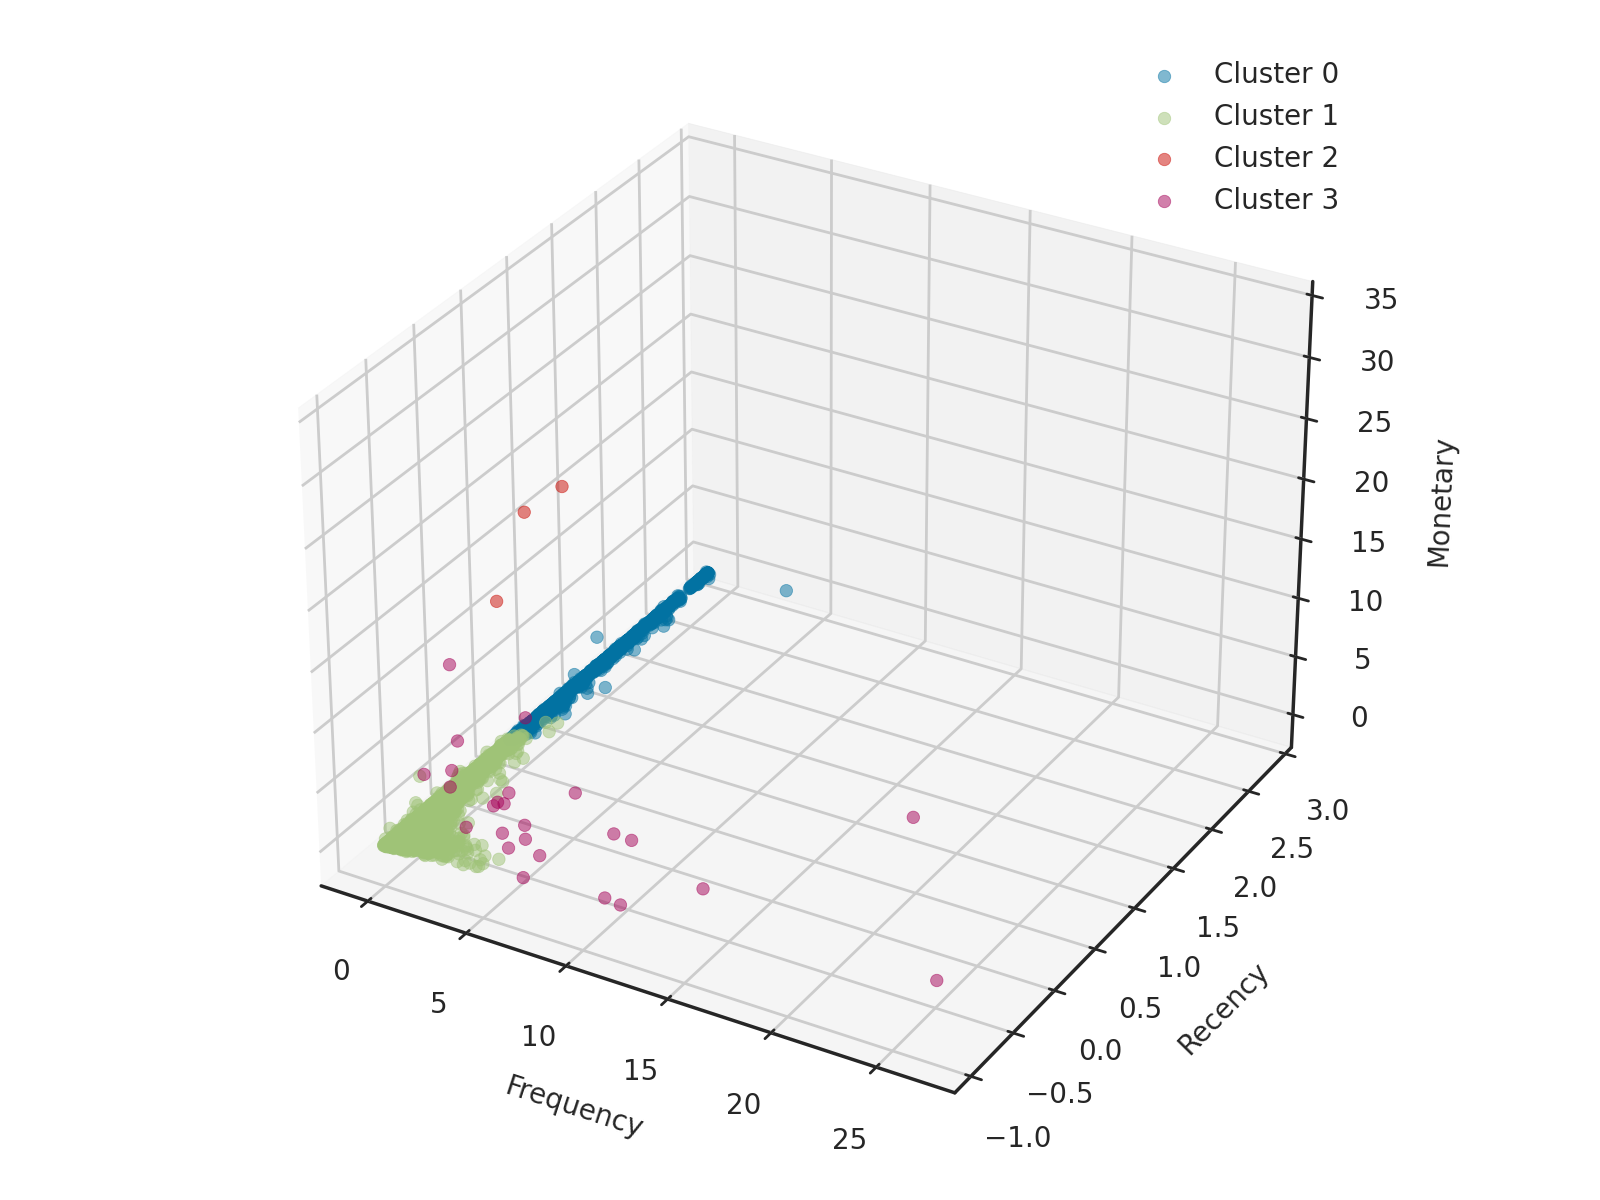

In [61]:
sns.set_style('white')
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1, 1, 1, projection='3d')

for i in kmeans_result['Cluster'].sort_values().unique():
  df = kmeans_result.where(kmeans_result['Cluster']==i)
  ax.scatter(df['Frequency_scaled'], df['Recency_scaled'], df['Monetary_scaled'],
            alpha = 0.5,
            label = 'Cluster ' + str(i))

ax.set_xlabel('Frequency', fontsize=10, labelpad=10)
ax.set_ylabel('Recency', fontsize = 10, labelpad=10)
ax.set_zlabel('Monetary', fontsize = 10, labelpad=10)

fig.tight_layout()
plt.legend()
plt.show()

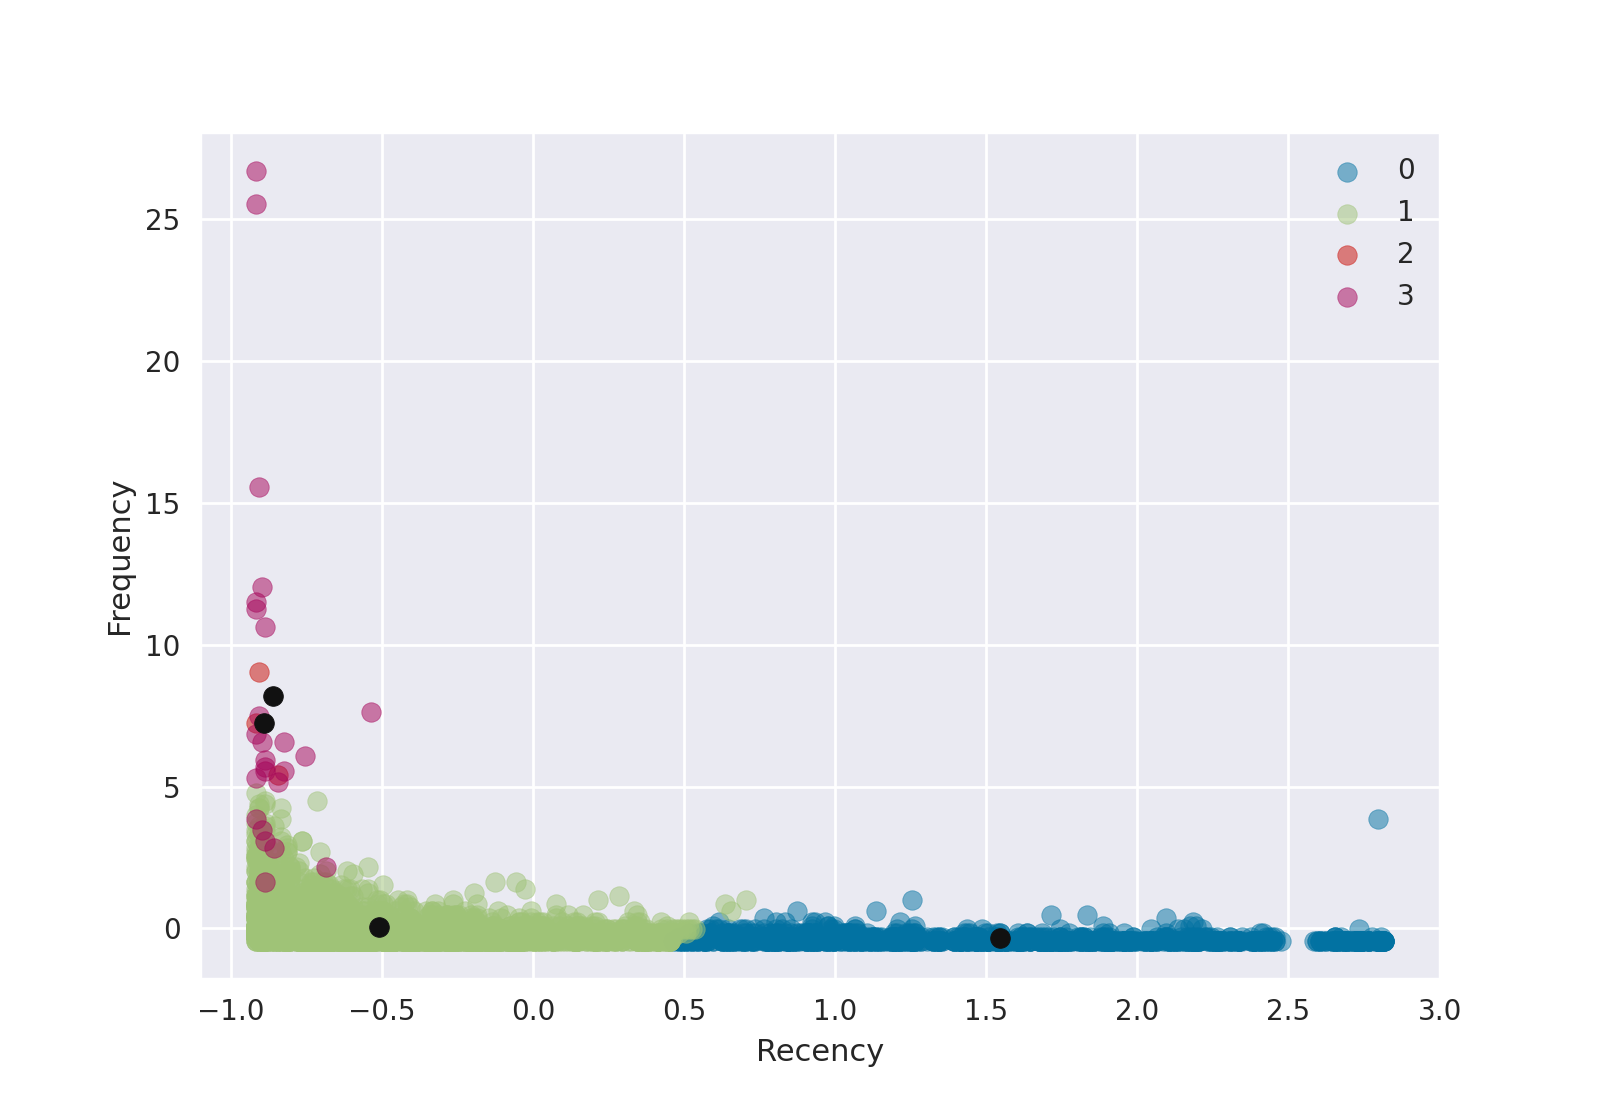

In [46]:
sns.set_style('darkgrid')
for i in kmeans_labels:
  subset = kmeans_result[kmeans_result['Cluster'] == i]
  plt.scatter(subset['Recency_scaled'].values.tolist(), subset['Frequency_scaled'].values.tolist(), label=i, alpha=0.5)
plt.scatter(centroids[:,0], centroids[:,1], s = 50, color = 'k')
plt.legend()
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.show()

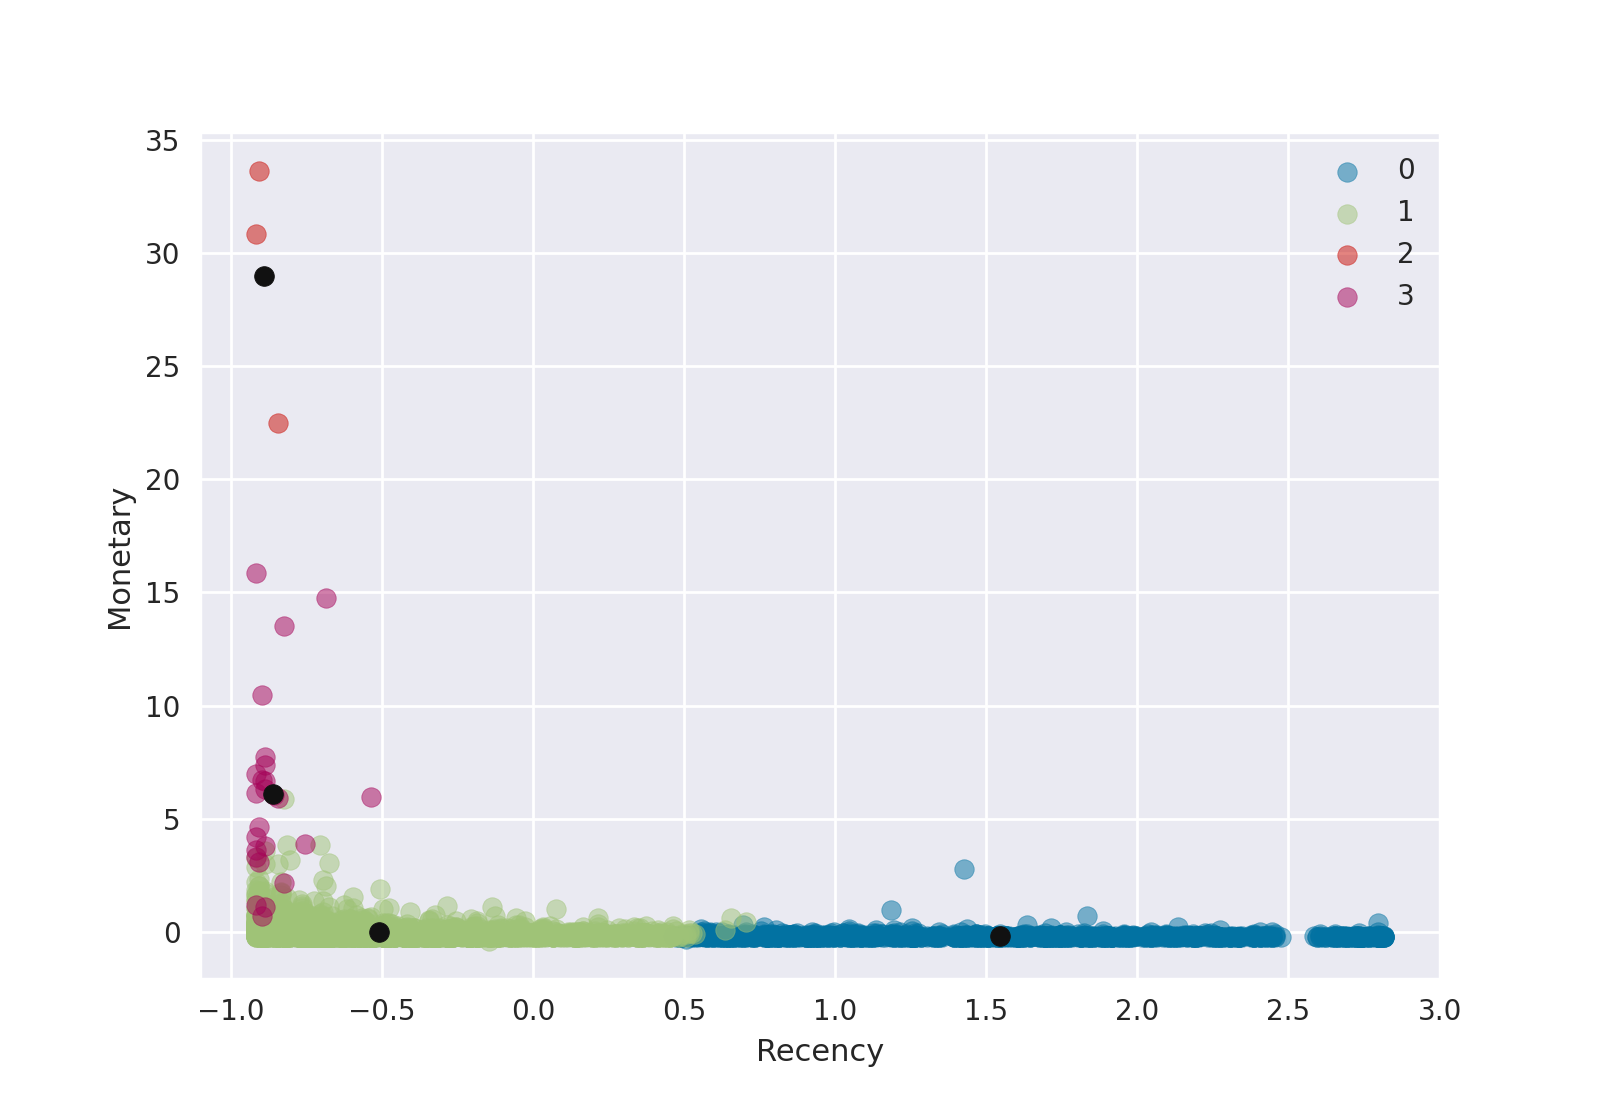

In [47]:
for i in kmeans_labels:
  subset = kmeans_result[kmeans_result['Cluster'] == i]
  plt.scatter(subset['Recency_scaled'].values.tolist() , subset['Monetary_scaled'].values.tolist() , label = i, alpha=0.5)
sns.set_style('darkgrid')
plt.scatter(centroids[:,0] , centroids[:,2] , s = 50, color = 'k')
plt.legend()
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.show()

To compare the RFM values of each cluster from a different angle, I retrieved the original values of recency, frequency, as well as monetary, and visualize them with box charts.

Text(0, 0.5, 'Monetary (dollars)')

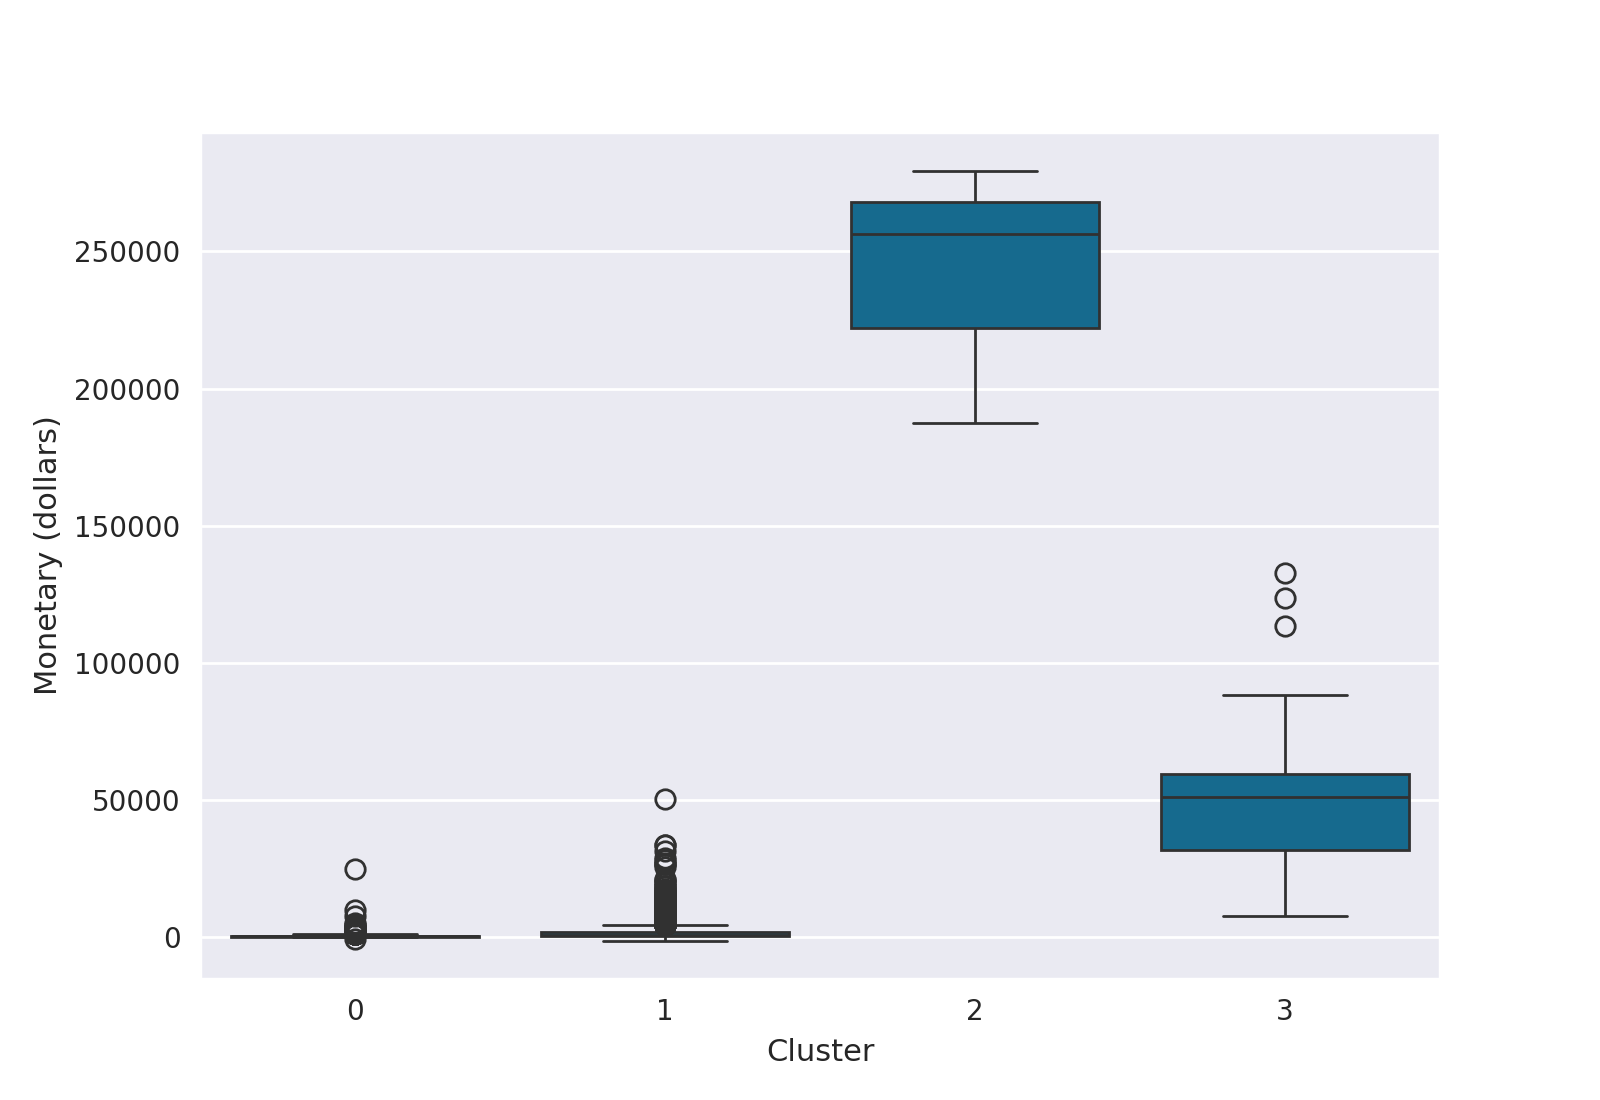

In [49]:
sns.boxplot(x='Cluster', y='Monetary', data=kmeans_result)
plt.ylabel('Monetary (dollars)')

Text(0, 0.5, 'Recency (days)')

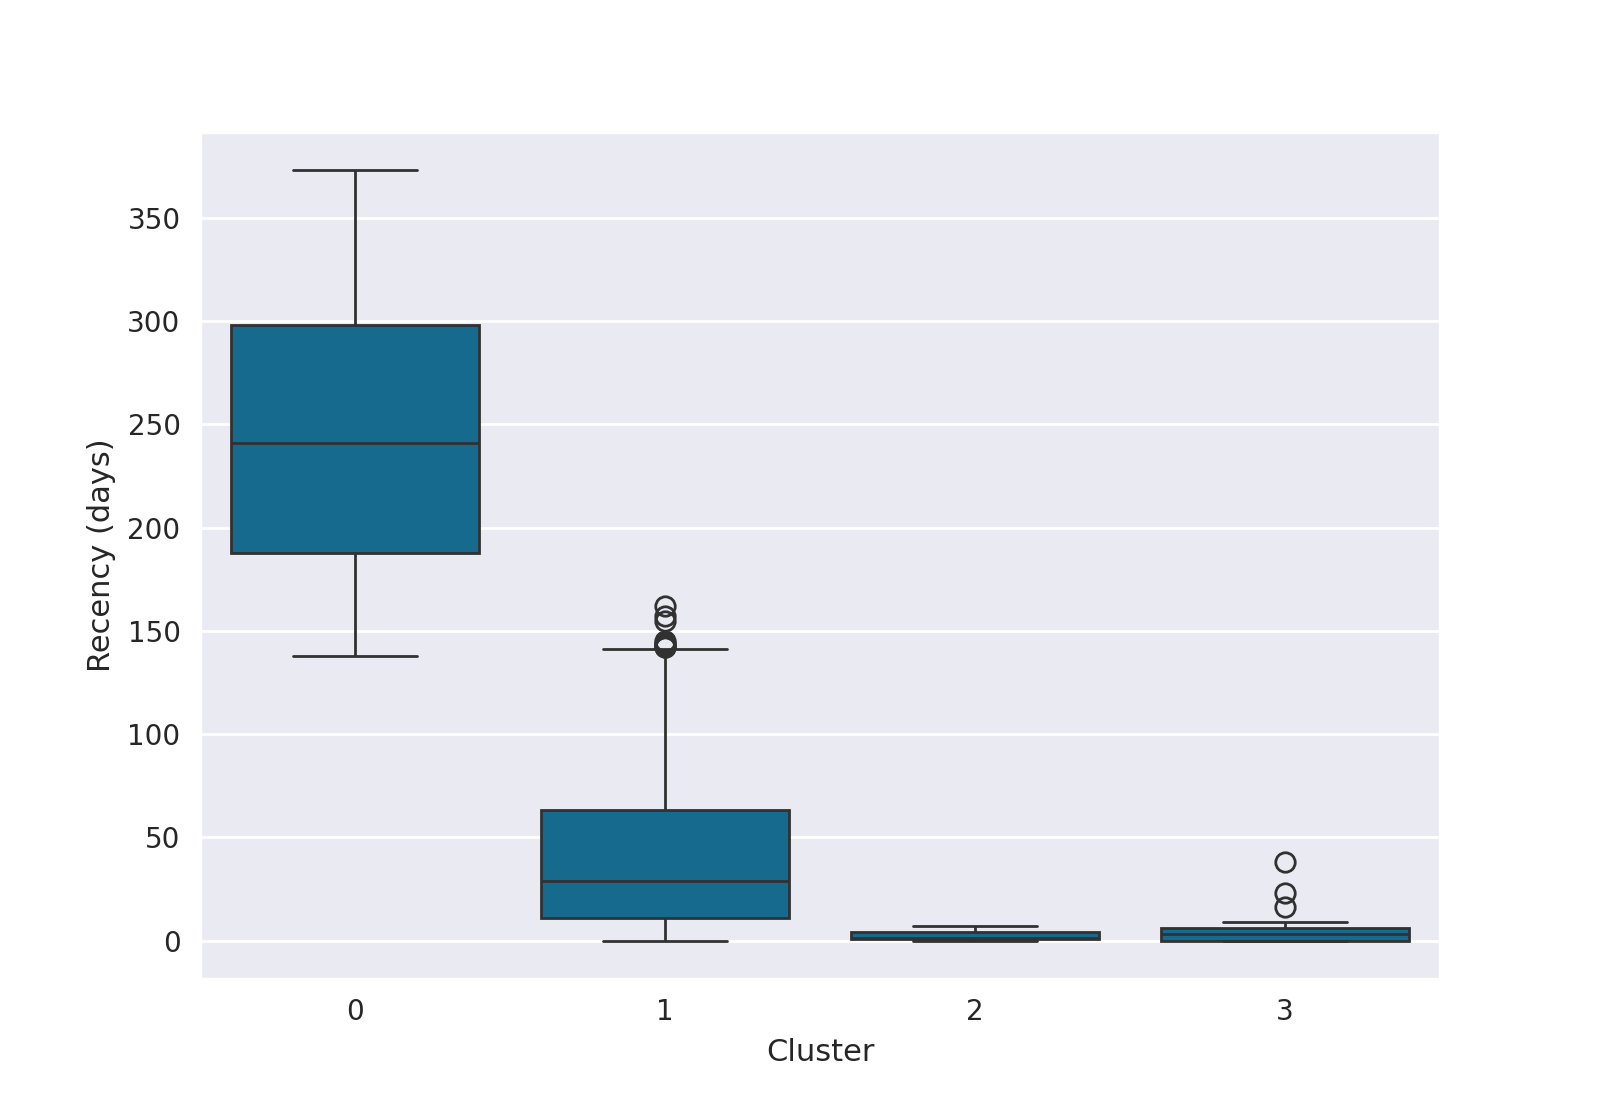

In [50]:
sns.boxplot(x='Cluster', y='Recency', data=kmeans_result)
plt.ylabel('Recency (days)')

Text(0, 0.5, 'Frequency (Times)')

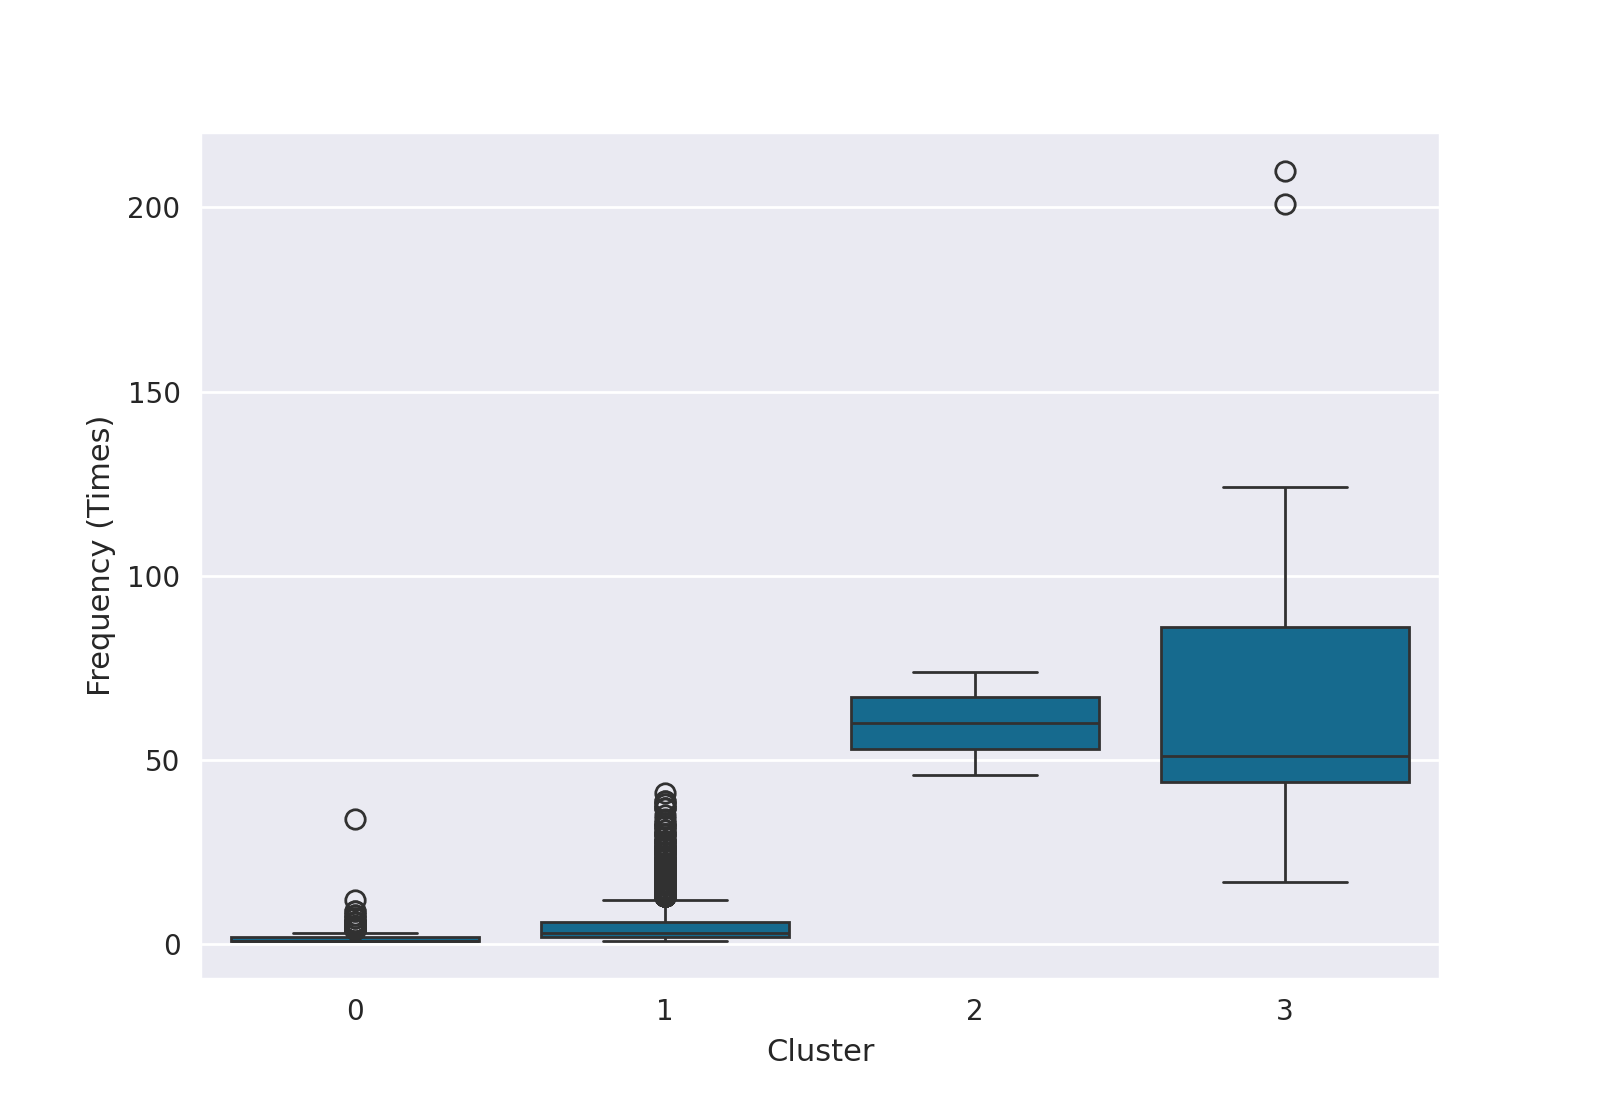

In [51]:
sns.boxplot(x='Cluster', y='Frequency', data=kmeans_result)
plt.ylabel('Frequency (Times)')

I observed from the above charts that clusters 2 and 3 are similar in recency and frequency but vary significantly in monetary value. Hence, I would like to further discuss the differences between them by calculating the proportion of monetary value from each cluster and the average monetary value per person in each cluster.

In [52]:
monetary_proportion = kmeans_result[['Cluster','Monetary']].groupby(['Cluster'], as_index=True).sum().reset_index()
monetary_proportion['Monetary Proportion'] = round(monetary_proportion['Monetary'] / data['Revenue'].sum(), 4)

population_proportion = kmeans_result['Cluster'].value_counts().reset_index()
population_proportion.columns = ['Cluster', 'Population']
population_proportion['Population Proportion'] = round(population_proportion['Population'] / data['CustomerID'].nunique(), 4)

proportions = monetary_proportion.merge(population_proportion, on='Cluster')
proportions['Average Monetary per Person'] = round(proportions['Monetary'] / proportions['Population'], 2)
proportions

,Cluster,Monetary,Monetary Proportion,Population,Population Proportion,Average Monetary per Person
0,0,530339.031,0.0636,1083,0.2496,489.69
1,1,5774535.873,0.6930,3228,0.7440,1788.89
2,2,723409.680,0.0868,3,0.0007,241136.56
3,3,1304583.490,0.1566,25,0.0058,52183.34


## DBSCAN
DBSCAN is a density-based algorithm that clusters data based on their density. Unlike K-means, DBSCAN does not require K, the number of clusters, as a hyperparameter. Instead, the number of clusters is automatically generated as one of the results when the algorithm ends.

DBSCAN will start from any data point, let's assume it starts from point A. Then, it searches within the range of "eps" (epsilon) distance around point A. If there are more than "min_samples" data points within the current ε range, we consider A as a core point. Then, we proceed to perform the same procedure for other data points within the "eps" distance range of point A. This process continues until there are no longer enough points within the "eps" range of a point A to meet the "min_samples" requirement. If there is no point within the "eps" range, we consider point A as a noise and label point A as cluster -1.

In [53]:
from sklearn.cluster import DBSCAN
DBSCAN = DBSCAN(eps=3, min_samples=2).fit(RFM_scaled)
DBSCAN_result = RFM_scaled.copy()
DBSCAN_result.columns = ['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled']
DBSCAN_result.insert(0, 'CustomerID', RFM['CustomerID'], True)
DBSCAN_result = pd.DataFrame.merge(DBSCAN_result, RFM,on='CustomerID')
DBSCAN_result['Cluster'] = DBSCAN.labels_
DBSCAN_result.head()

,CustomerID,Recency_scaled,Frequency_scaled,Monetary_scaled,Recency,Frequency,Monetary,Cluster
0,12346.0,2.334858,-0.424675,-0.232695,325,1,0.00,0
1,12347.0,-0.905199,0.354080,0.289532,1,7,4310.00,0
2,12348.0,-0.175186,-0.035297,-0.014930,74,4,1797.24,0
3,12349.0,-0.735196,-0.424675,-0.019739,18,1,1757.55,0
4,12350.0,2.174855,-0.424675,-0.192177,309,1,334.40,0


In [54]:
import collections, numpy
counter = collections.Counter(DBSCAN.labels_)
counter

Counter({0: 4326, -1: 9, 1: 2, 2: 2})

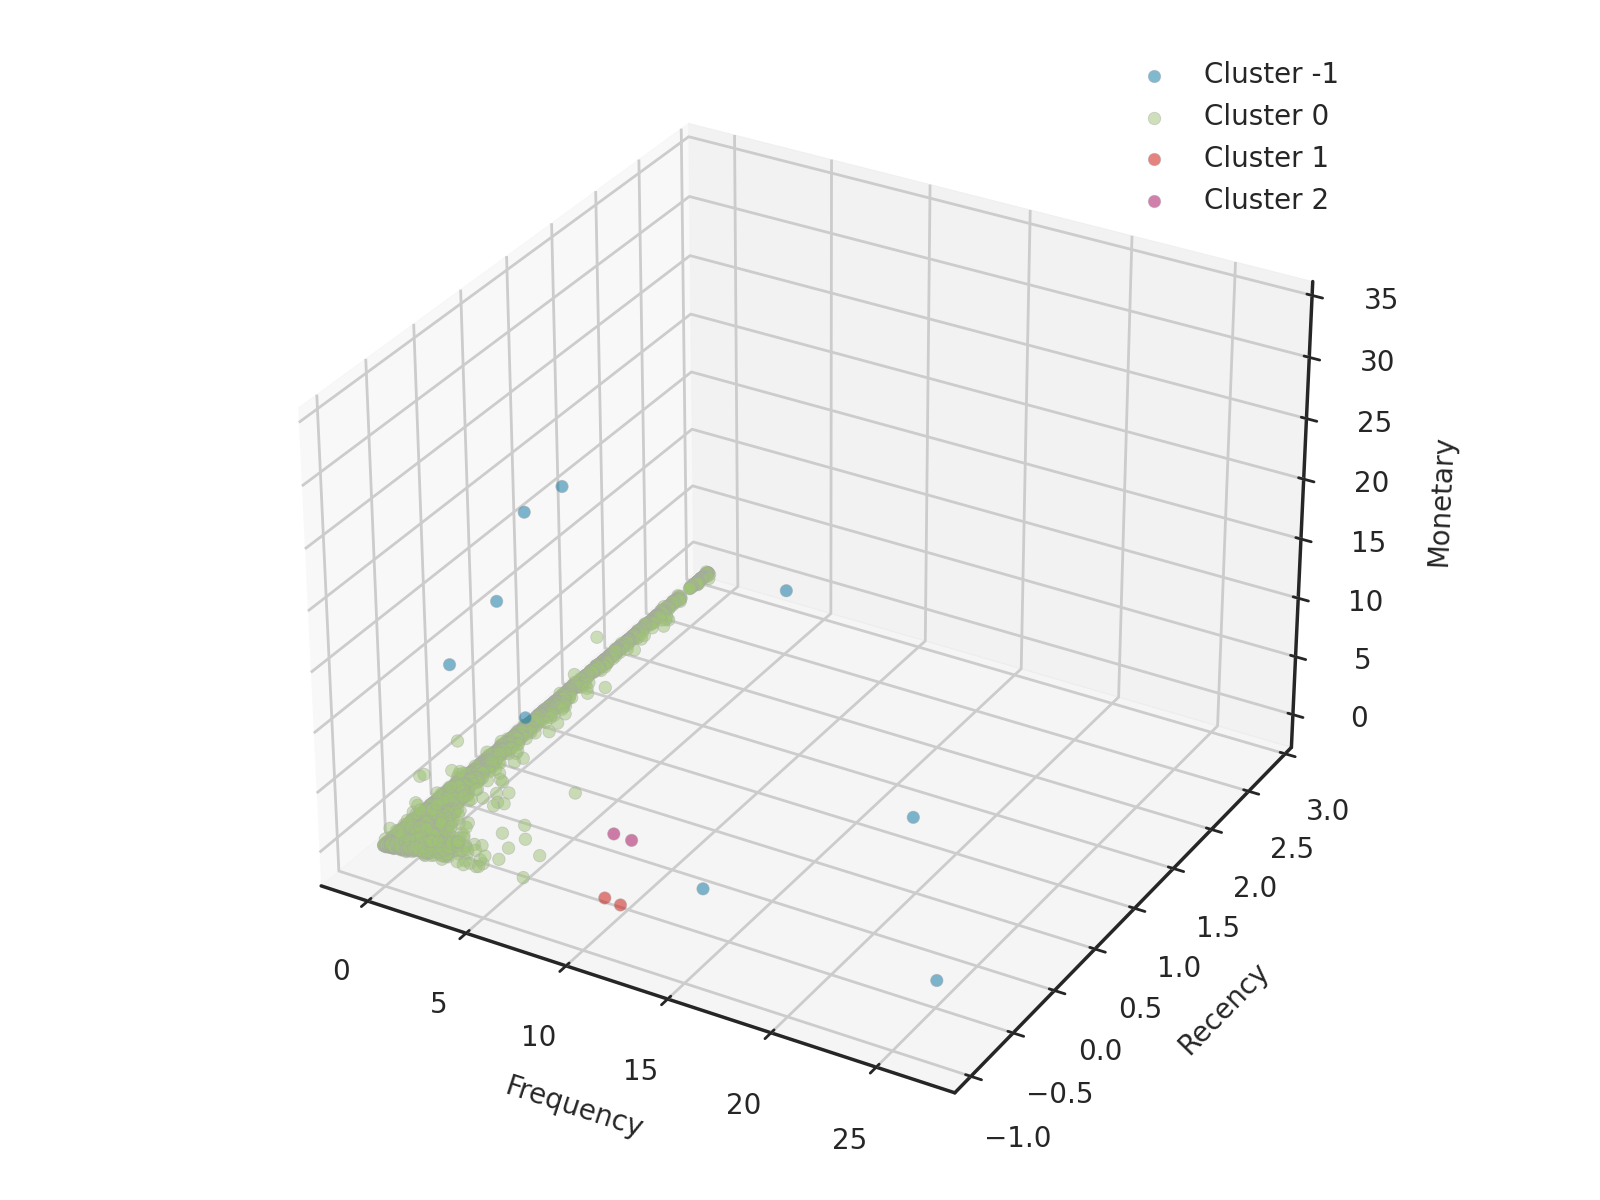

In [62]:
sns.set_style('white')
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1, 1, 1, projection='3d')

for i in DBSCAN_result['Cluster'].sort_values().unique():
  df = DBSCAN_result.where(DBSCAN_result['Cluster']==i)
  ax.scatter(df['Frequency_scaled'], df['Recency_scaled'], df['Monetary_scaled'],
            alpha = 0.5,
            edgecolor = 'darkgrey',
            label = 'Cluster ' + str(i))

ax.set_xlabel('Frequency', fontsize=10, labelpad=10)
ax.set_ylabel('Recency', fontsize = 10, labelpad=10)
ax.set_zlabel('Monetary', fontsize = 10, labelpad=10)

fig.tight_layout()
plt.legend()
plt.show()

Due to the distribution of data, the clustering result of DBSCAN is not as diverse as that of K-means. Most of the customers are assigned to cluster 0. In my opinion, this clustering result is not ideal for customer segmentation, as it is practically similar to having no segmentation at all. Therefore, I have decided to use the labels generated by K-means as the segmentation result.

## RFM scoring + Kmeans

In [64]:
def R_score(x, p, d):
  if x <= d[p][0.25]:
    return 4
  elif x <= d[p][0.50]:
    return 3
  elif x <= d[p][0.75]:
    return 2
  else:
    return 1

def FM_score(x, p, d):
  if x <= d[p][0.25]:
    return 1
  elif x <= d[p][0.50]:
    return 2
  elif x <= d[p][0.75]:
    return 3
  else:
    return 4

quantiles = RFM_scaled.quantile(q=[0.25,0.5,0.75])
RFM_scored = RFM_scaled.copy()
RFM_scored['R_score'] = RFM_scaled['Recency_scaled'].apply(R_score, args=('Recency_scaled',quantiles,))
RFM_scored['F_score'] = RFM_scaled['Frequency_scaled'].apply(FM_score, args=('Frequency_scaled',quantiles,))
RFM_scored['M_score'] = RFM_scaled['Monetary_scaled'].apply(FM_score, args=('Monetary_scaled',quantiles,))
RFM_scored.head()

,Recency_scaled,Frequency_scaled,Monetary_scaled,R_score,F_score,M_score
0,2.334858,-0.424675,-0.232695,1,1,1
1,-0.905199,0.354080,0.289532,4,4,4
2,-0.175186,-0.035297,-0.014930,2,3,4
3,-0.735196,-0.424675,-0.019739,3,1,4
4,2.174855,-0.424675,-0.192177,1,1,2


# Discussion

According to the result of K-means, I name each cluster of customers, describe their features, and brainstorm corresponding actions as follows.

# Conclusion

Segmenting consumers is a crucial aspect of managing customer relationships and increasing revenue. It's essential to allocate costs to effective and efficient strategies in order to truly boost sales. In this article, I conduct two kinds of methdologies to implement customer segmentation. It turns out that K-means yields superior results in this dataset.